## Q-value analysis

The policy gradient is biased, because the critic gradient in the policy gradient update is taken with respect to the soft permutation, whereas the critic is trained to minimize the MSE with the hard permutation. In this notebook, we investigate how this might be rectified

First, we will look at the Q-values corresponding to various hard and soft permutations given a single state and an actor and critic network trained at various numbers of epochs. Based on intuition and informal results, it appears that the actor network learns to produce actions (soft-permutations) to maximize its reward function effectively (its objective is the negative Q-value) but the critic network has learned to produce Q-values for rounded soft-permutations (hard permutations, or binary matrices) that minimizes the MSE of the return. In other words, the actor has learned to game the critic to make it output arbitrarily larger and larger Q-values for soft-permutation inputs.

Ideally, we can prevent the actor from "gaming" the critic to produce arbitrarily large Q-values, and instead try to have the Q-values for soft-permutations match those of the corresponding hard-permutation. Perhaps; add a penalty to the actor update to discourage the Q-value for the soft-permutation from deviating too far from the Q-value for the corresponding hard-permutation.

In [7]:
import torch
import numpy as np
import os
from itertools import permutations
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
named_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

from sklearn.utils.linear_assignment_ import linear_assignment
import seaborn as sns; sns.set()
%matplotlib inline

#mwm2D_10_path = '/home/pemami/Workspace/sinkhorn-policy-gradient.pytorch/results/models/mwm2D/spg/siamese/888/'
#mwm2D_5_path = '/home/pemami/Workspace/sinkhorn-policy-gradient.pytorch/results/models/mwm2D/spg/siamese/999/'
# biased
#mwm2D_10_path = '/data/pemami/spg/results/models/mwm2D/spg/siamese/5aba73738f5dab31550cfcbf'
# unbiased
mwm2D_10_path = '/data/pemami/spg/results/models/mwm2D/spg/siamese/5abb2f3d8f5dab31550cfccf'

np.random.seed(0)
torch.manual_seed(5)

batch_size = 100

def plot_epoch(actor_path, critic_path, state, epoch, N):
    actor = torch.load(actor_path, map_location=lambda storage, loc: storage)
    actor.cuda()
    actor.cuda_after_load()
    critic = torch.load(critic_path, map_location=lambda storage, loc: storage)
    critic.cuda()
    critic.cuda_after_load()

    soft_perms, hard_perms, _, _ = actor.forward(state)
    hard_Qs = critic.forward(state, hard_perms).squeeze(2).data.cpu().numpy()
    soft_Qs = critic.forward(state, soft_perms).squeeze(2).data.cpu().numpy()

    fig, ax = plt.subplots()
    plt.title("Penalty, Q-values at epoch {}".format(epoch), fontweight='bold', fontsize=16)
    #plt.hist(hard_Qs, bins=20, label='hard Q', alpha=0.5)
    #plt.hist(soft_Qs, bins=20, label='soft Q', alpha=0.5)
    plt.scatter(soft_Qs, hard_Qs)
    plt.plot(list(range(4,10)), list(range(4,10)), color='r')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Soft Q-value', fontsize=14, fontweight='bold')
    plt.ylabel('Hard Q-value', fontsize=14, fontweight='bold')
    plt.xlim([4,9])
    plt.ylim([4,9])
    plt.legend(prop={'size': 14, 'weight': 'bold'})
    plt.grid(True)
    
    print('Actor loss = {}'.format(-np.mean(soft_Qs)))
    plt.savefig('results/analysis/unbiased-pg-epoch-{}.png'.format(epoch), dpi=300)

/home/pemami/.conda/envs/research-dev/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'spg.layers.Sinkhorn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
No handles with labels found to put in legend.


torch.Size([100, 20, 2])
Actor loss = -5.022702217102051


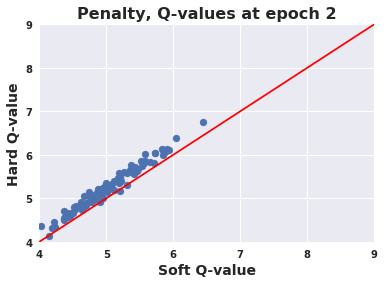

In [8]:
N = 10

# For each epoch, load the actor and critic
# For 25 different states, plot a histogram of Q-values for the hard and soft permutations                             
state = torch.FloatTensor(batch_size, 4, N).uniform_(0, 1) 
g1 = torch.transpose(state[:,0:2, :], 1, 2)
g2 = torch.transpose(state[:,2:4, :], 1, 2)
state = torch.cat([g1, g2], dim=1)
state = state.cuda()
state = torch.autograd.Variable(state, volatile=True)
print(state.size())

epoch = 2
actor_path = os.path.join(mwm2D_10_path, 'actor-epoch-{}.pt'.format(epoch))
critic_path = os.path.join(mwm2D_10_path, 'critic-epoch-{}.pt'.format(epoch))
plot_epoch(actor_path, critic_path, state, epoch, N)

/home/pemami/.conda/envs/research-dev/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'spg.layers.Sinkhorn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
No handles with labels found to put in legend.


Actor loss = -6.467129707336426


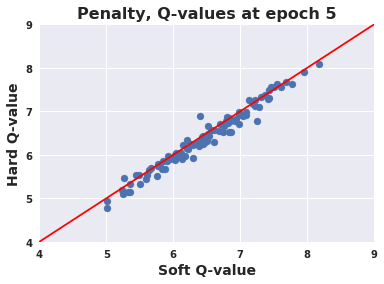

In [9]:
epoch = 5
actor_path = os.path.join(mwm2D_10_path, 'actor-epoch-{}.pt'.format(epoch))
critic_path = os.path.join(mwm2D_10_path, 'critic-epoch-{}.pt'.format(epoch))
plot_epoch(actor_path, critic_path, state, epoch, N)

/home/pemami/.conda/envs/research-dev/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'spg.layers.Sinkhorn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
No handles with labels found to put in legend.


Actor loss = -6.337184906005859


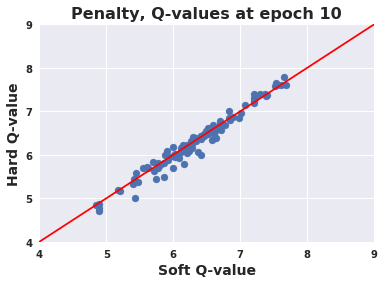

In [10]:
epoch = 10
actor_path = os.path.join(mwm2D_10_path, 'actor-epoch-{}.pt'.format(epoch))
critic_path = os.path.join(mwm2D_10_path, 'critic-epoch-{}.pt'.format(epoch))
plot_epoch(actor_path, critic_path, state, epoch, N)

/home/pemami/.conda/envs/research-dev/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'spg.layers.Sinkhorn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
No handles with labels found to put in legend.


Actor loss = -6.398907661437988


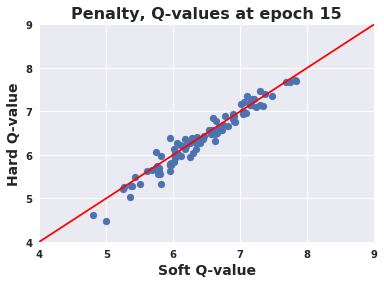

In [11]:
epoch = 15
actor_path = os.path.join(mwm2D_10_path, 'actor-epoch-{}.pt'.format(epoch))
critic_path = os.path.join(mwm2D_10_path, 'critic-epoch-{}.pt'.format(epoch))
plot_epoch(actor_path, critic_path, state, epoch, N)

/home/pemami/.conda/envs/research-dev/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'spg.layers.Sinkhorn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
No handles with labels found to put in legend.


Actor loss = -6.570685386657715


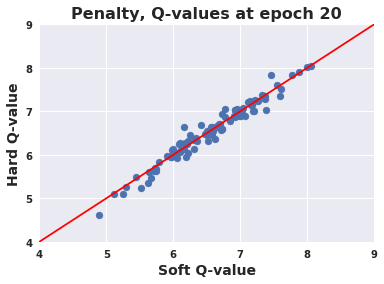

In [12]:
epoch = 20
actor_path = os.path.join(mwm2D_10_path, 'actor-epoch-{}.pt'.format(epoch))
critic_path = os.path.join(mwm2D_10_path, 'critic-epoch-{}.pt'.format(epoch))
plot_epoch(actor_path, critic_path, state, epoch, N)